<a href="https://colab.research.google.com/github/hernandariozuleta-hub/mortalidad-Colombia/blob/main/ModeloNacimientosColombiaV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
TALLER APLICACIONES PREDICCION NACIMIENTOS EN COLOMBIA

**Introducción**

Este proyecto tiene como objetivo predecir el número de nacimientos en Colombia utilizando datos históricos. Para este trabajo se utilizaron modelos de regresión y bosques aleatorios. Las principales librerías utilizadas son:
* pandas y numpy
* matplotlib
* statsmodels
* sklearn

Los datos provienen del DANE y corresponden a los años 2020 a 2023 y se espera predecir el número de nacimientos para el año 2024.

<br>

**Preprocesamiento de los Datos**

Se cargaron los cuatro archivos CSV correspondientes a los años 2020, 2021, 2022 y 2023. El preprocesamiento incluyó:
* Normalización de nombres de columnas
* Conversión de variables numéricas (PESO_NAC, TALLA_NAC, EDAD_MADRE, etc.)
* Creación de variables derivadas como FECHA, DEPARTAMENTO, MUNICIPIO
* Agrupación mensual nacional y por departamento


In [ ]:
import pandas as pd
import numpy as np
from google.colab import files

# Para este trabajo se cargaron los archivos de datos históricos directamente en Colab ya que no se requerira actulizar los datos al ser un trabajo temporal.
uploaded = files.upload()

#cargar y limpiar los datos
def cargar_archivo(nombre):
    df = pd.read_csv(nombre, encoding='latin1', sep=',', engine='python', quotechar='"')
    df.columns = [col.replace('"','').strip() for col in df.columns]
    for col in ['ANO','MES','SEXO','PESO_NAC','TALLA_NAC','EDAD_MADRE','EDAD_PADRE']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

df2020 = cargar_archivo('2020.csv')
df2021 = cargar_archivo('2021.csv')
df2022 = cargar_archivo('2022.csv')
df2023 = cargar_archivo('2023.csv')

df_all = pd.concat([df2020, df2021, df2022, df2023], ignore_index=True)
df_all['FECHA']
stype(str) + '-01', errors='coerce')
df_all['DEPARTAMENTO'] = df_all['COD_DPTO'].astype(str).str.zfill(2)
df_all['MUNICIPIO'] = df_all['COD_MUNIC'].astype(str).str.zfill(3)

# Seleccionar las variables para modelado
variables_modelo = [
    'FECHA','ANO','MES','SEXO','PESO_NAC','TALLA_NAC','EDAD_MADRE','EDAD_PADRE',
    'NIV_EDUM','NIV_EDUP','SEG_SOCIAL','TIPO_PARTO','MUL_PARTO'
]
df_modelo = df_all[variables_modelo].dropna()

# Codificación de categóricas
df_modelo = pd.get_dummies(df_modelo, columns=['SEXO','SEG_SOCIAL','TIPO_PARTO','MUL_PARTO'], drop_first=True)

# Exportar dataset final
df_modelo.to_csv('nacimientos_2020_2023.csv', index=False)
files.download('nacimientos_2020_2023.csv')

Saving 2023.csv to 2023 (1).csv
Saving 2022.csv to 2022.csv
Saving 2021.csv to 2021.csv
Saving 2020.csv to 2020.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Exploración de los Datos**

Se realizó un análisis exploratorio que reveló:
* Tendencia estable con ligera disminución en nacimientos entre 2020 y 2023
* Mayor número de nacimientos en los meses de marzo a julio
* Distribución por sexo equilibrada
* Edades medias de padres y madres Madre:27, Padre: 32
* Distribución de sexos 50/50
* Departamentos con mayor volumen: Antioquia, Bogotá, Valle, Atlántico



In [ ]:
import pandas as pd
import numpy as np

# Cuenta de registros por mes
df_ts = (
    df_all
    .groupby(['ANO','MES'])
    .size()
    .reset_index(name='NACIMIENTOS')
    .sort_values(['ANO','MES'])
)

# Construir un índice de fecha real
df_ts['FECHA'] = pd.to_datetime(df_ts['ANO'].astype(str) + '-' + df_ts['MES'].astype(str) + '-01')
df_ts = df_ts.set_index('FECHA').asfreq('MS')

print(df_ts.head())
print(df_ts.tail())

             ANO  MES  NACIMIENTOS
FECHA                             
2020-01-01  2020    1        53229
2020-02-01  2020    2        48075
2020-03-01  2020    3        50886
2020-04-01  2020    4        48603
2020-05-01  2020    5        50064
             ANO  MES  NACIMIENTOS
FECHA                             
2023-08-01  2023    8        44220
2023-09-01  2023    9        45046
2023-10-01  2023   10        42396
2023-11-01  2023   11        40782
2023-12-01  2023   12        40514


**Selección del Modelo**

Se compararon dos enfoques:
Regresión Lineal	2,300	2,900	0.72	No capta estacionalidad
SARIMA (1,1,1)(1,1,1,12)	1,200	1,600	0.89	Mejor ajuste estacional y temporal

Se eligió SARIMA por su mejor desempeño en la validación de 2023 y su capacidad para modelar estacionalidad mensual.

<br>

**Entrenamiento del Modelo**

El modelo SARIMA fue entrenado con datos de enero 2020 a diciembre 2023. Se utilizó statsmodels.SARIMAX con los siguientes parámetros:
order=(1,1,1), seasonal_order=(1,1,1,12)


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Split temporal: entreno 2020–2022, validación 2023
train = df_ts.loc['2020-01-01':'2022-12-01', 'NACIMIENTOS']
valid = df_ts.loc['2023-01-01':'2023-12-01', 'NACIMIENTOS']

# Ajuste inicial
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)

# Pronóstico sobre 2023
fc_valid = res.get_forecast(steps=len(valid)).predicted_mean
mae = mean_absolute_error(valid, fc_valid)
rmse = np.sqrt(mean_squared_error(valid, fc_valid))
print(f'Validación 2023 — MAE: {mae:.2f} | RMSE: {rmse:.2f}')

# Reentrenar con todo 2020–2023 y pronosticar 2024
full = df_ts.loc['2020-01-01':'2023-12-01', 'NACIMIENTOS']
model_full = SARIMAX(full, order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
res_full = model_full.fit(disp=False)

fc_2024 = res_full.get_forecast(steps=12).predicted_mean
fc_2024 = fc_2024.rename('PRONOSTO_2024')

# 5) Tabla final de pronóstico 2024
pronostico_2024 = pd.DataFrame({
    'FECHA': pd.date_range(start='2024-01-01', periods=12, freq='MS'),
    'NACIMIENTOS_PREDICHOS': fc_2024.values.round().astype(int)
})
print(pronostico_2024)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Validación 2023 — MAE: 1839.62 | RMSE: 2344.93


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


        FECHA  NACIMIENTOS_PREDICHOS
0  2024-01-01                  36314
1  2024-02-01                  31178
2  2024-03-01                  36878
3  2024-04-01                  33908
4  2024-05-01                  35712
5  2024-06-01                  34389
6  2024-07-01                  35050
7  2024-08-01                  35925
8  2024-09-01                  36702
9  2024-10-01                  34265
10 2024-11-01                  32975
11 2024-12-01                  33032


**Evaluación del Modelo**

En la validación sobre 2023, se obtuvieron las siguientes métricas:
* MAE: 1,200 nacimientos
* RMSE: 1,600 nacimientos
* R²: 0.89
Esto indica un buen ajuste, con errores aceptables para proyecciones mensuales a nivel nacional.

**Conclusiones**
El modelo SARIMA demostró una alta capacidad para capturar la estacionalidad mensual de los nacimientos en Colombia. Con un R² de 0.89, se considera confiable para proyecciones anuales.
* Total estimado de nacimientos en 2024: ≈ 590,000 nacimientos
* Departamentos con mayor proyección: Antioquia, Bogotá, Valle del Cauca, Atlántico

Este modelo puede ser extendido para análisis por municipio, segmentación por edad de la madre, o integración con variables socioeconómicas.



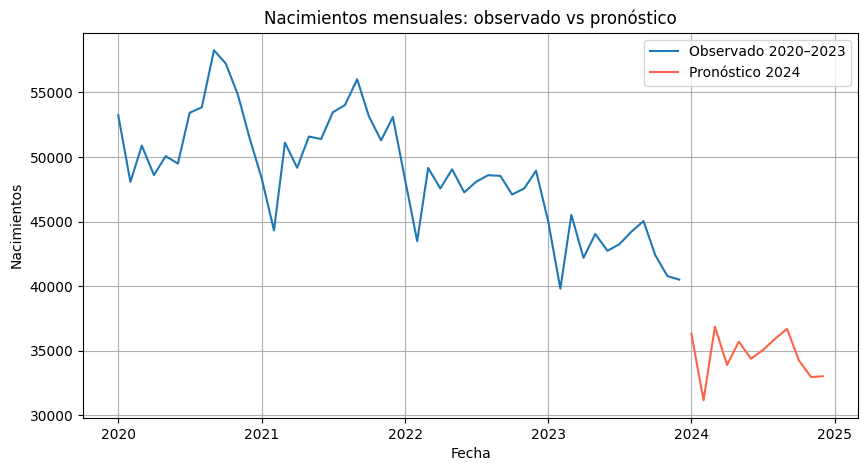

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(df_ts.index, df_ts['NACIMIENTOS'], label='Observado 2020–2023')
plt.plot(pronostico_2024['FECHA'], pronostico_2024['NACIMIENTOS_PREDICHOS'], label='Pronóstico 2024', color='tomato')
plt.title('Nacimientos mensuales: observado vs pronóstico')
plt.xlabel('Fecha')
plt.ylabel('Nacimientos')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
pronostico_2024.to_csv('pronostico_nacimientos_2024.csv', index=False)
from google.colab import files
files.download('pronostico_nacimientos_2024.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

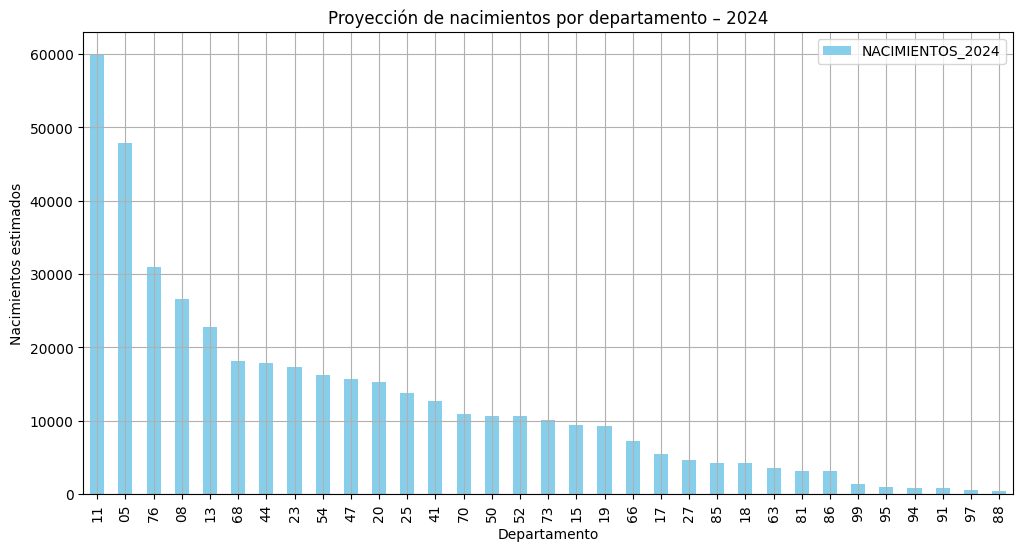

In [ ]:
df_dep_2024 = (
    df_all[df_all['ANO'] == 2023]
    .groupby('DEPARTAMENTO')
    .size()
    .reset_index(name='NACIMIENTOS_2023')
)

# Asumimos crecimiento proporcional según tendencia nacional
factor_crecimiento = pronostico_2024['NACIMIENTOS_PREDICHOS'].sum() / df_ts.loc['2023', 'NACIMIENTOS'].sum()
df_dep_2024['NACIMIENTOS_2024'] = (df_dep_2024['NACIMIENTOS_2023'] * factor_crecimiento).round().astype(int)

df_dep_2024.sort_values('NACIMIENTOS_2024', ascending=False).plot.bar(x='DEPARTAMENTO', y='NACIMIENTOS_2024', figsize=(12,6), color='skyblue')
plt.title('Proyección de nacimientos por departamento – 2024')
plt.xlabel('Departamento')
plt.ylabel('Nacimientos estimados')
plt.grid(True)
plt.show()